In [1]:
#! pip install plot-metric
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_curve
import matplotlib.pyplot as plt
import torch
import joblib

path_csv = "../../../Thesis_data/processed_data/"
path_model = "../../../Thesis_data/Models/"

In [2]:
#https://mikulskibartosz.name/how-to-reduce-memory-usage-in-pandas

def rm(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [3]:
results = pd.DataFrame(columns=["Model", "AUROC", "Balanced Accuracy", "F1", "Recall", "Precision"])

def evaluation(y_test_input, y_pred_input, model_name, y_pred_proba_input):

    auroc = round(roc_auc_score(y_test_input, y_pred_proba_input),3)
    bal_acc = round(balanced_accuracy_score(y_test_input, y_pred_input),3)
    f1 = round(f1_score(y_test_input, y_pred_input),3)
    recall = round(recall_score(y_test_input, y_pred_input),3)
    precis = round(precision_score(y_test_input, y_pred_input),3)

    results.loc[len(results)+1] = [type(model_name).__name__, auroc, bal_acc, f1, recall, precis]

    print("AUROC Score: ", auroc)
    print("Balanced Accuracy Score: ", bal_acc)
    print("F1 Score: ", f1)
    print("Recall Score: ", recall)
    print("Precision Score: ", precis)
    cm = confusion_matrix(y_test_input, y_pred_input)

    fig, ax = plt.subplots(figsize=(4, 6))
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
    
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

In [4]:
X_test = pd.read_csv(path_csv + "ontime_reporting_X_test.csv")
y_test = pd.read_csv(path_csv + "ontime_reporting_y_test.csv")

In [5]:
X_test = rm(X_test)
y_test = np.ravel(y_test)

Memory usage of dataframe is 314.23 MB
Memory usage after optimization is: 78.56 MB
Decreased by 75.0%


## Evaluate Logistic Regression baseline model

In [6]:
logreg_baseline = pickle.load(open(path_model + "logreg_baseline.pkl", "rb"))
y_pred_logreg_baseline = logreg_baseline.predict(X_test)
y_pred_prob_logreg_baseline = logreg_baseline.predict_proba(X_test)[:, 1]

AUROC Score:  0.739
Balanced Accuracy Score:  0.663
F1 Score:  0.473
Recall Score:  0.377
Precision Score:  0.634


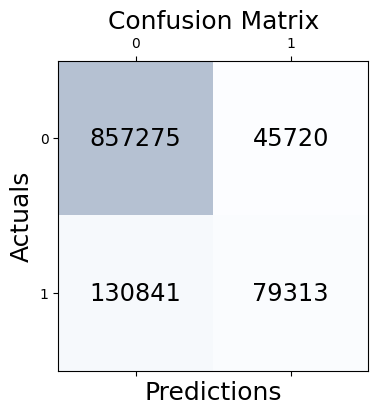

In [7]:
evaluation(y_test, y_pred_logreg_baseline, logreg_baseline, y_pred_prob_logreg_baseline)

## Evaluate XGBoost baseline model

In [8]:
xgb_class_baseline = pickle.load(open(path_model + "XGBoost_baseline.pkl", "rb")) #xgb version 1.7.5
y_pred_xgb_baseline = xgb_class_baseline.predict(X_test)
y_pred_prob_xgb_baseline = xgb_class_baseline.predict_proba(X_test)[:, 1]

C:\Users\Rvanl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:160: UserWarning: [16:13:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


AUROC Score:  0.794
Balanced Accuracy Score:  0.665
F1 Score:  0.48
Recall Score:  0.371
Precision Score:  0.682


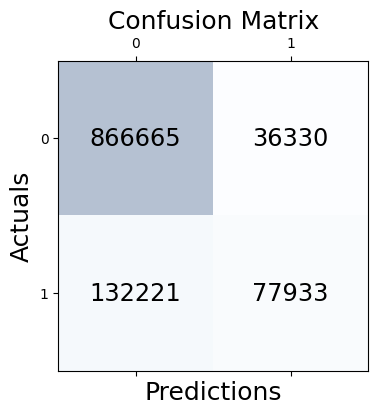

In [9]:
evaluation(y_test, y_pred_xgb_baseline, xgb_class_baseline, y_pred_prob_xgb_baseline)

## Evaluate TabNet baseline model

In [10]:
tabnet_baseline = torch.load(path_model + "TabNet_baseline.pt")
y_pred_tabnet_baseline = tabnet_baseline.predict(X_test.values)
y_pred_prob_tabnet_baseline = tabnet_baseline.predict_proba(X_test.values)[:, 1]

AUROC Score:  0.774
Balanced Accuracy Score:  0.662
F1 Score:  0.473
Recall Score:  0.367
Precision Score:  0.666


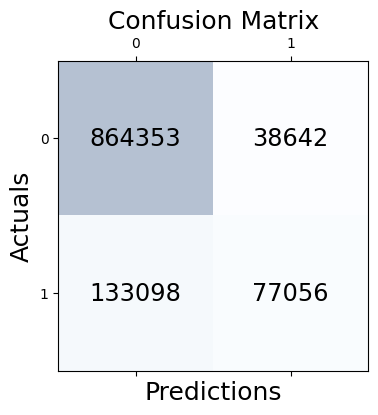

In [11]:
evaluation(y_test, y_pred_tabnet_baseline, tabnet_baseline, y_pred_prob_tabnet_baseline)

## Evaluate Random Forests baseline model

In [12]:
rf_baseline = joblib.load(path_model + "rf_baseline.joblib")
y_pred_rf_baseline = rf_baseline.predict(X_test)
y_pred_prob_rf_baseline = rf_baseline.predict_proba(X_test)[:, 1]

C:\Users\Rvanl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Rvanl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


AUROC Score:  0.797
Balanced Accuracy Score:  0.669
F1 Score:  0.488
Recall Score:  0.378
Precision Score:  0.688


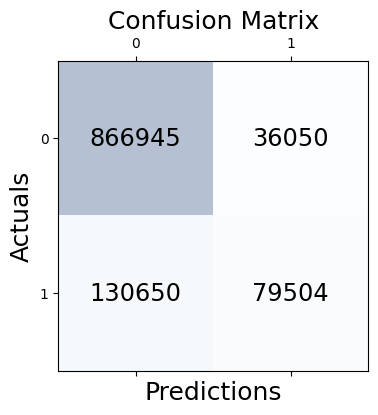

In [13]:
evaluation(y_test, y_pred_rf_baseline, rf_baseline, y_pred_prob_rf_baseline)

In [14]:
results.sort_values(by=["AUROC"], ascending=False)

,Model,AUROC,Balanced Accuracy,F1,Recall,Precision
4,RandomForestClassifier,0.797,0.669,0.488,0.378,0.688
2,XGBClassifier,0.794,0.665,0.480,0.371,0.682
3,TabNetClassifier,0.774,0.662,0.473,0.367,0.666
1,LogisticRegression,0.739,0.663,0.473,0.377,0.634


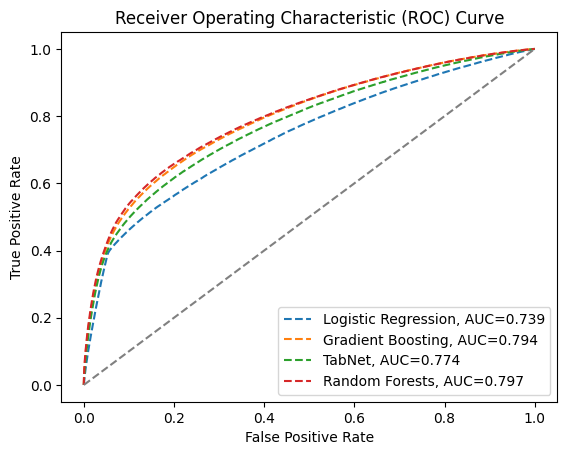

<Figure size 1400x1200 with 0 Axes>

In [15]:
#Plot AUROC for LogReg
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_logreg_baseline)
auc = round(roc_auc_score(y_test, y_pred_prob_logreg_baseline), 3)
plt.plot(fpr, tpr, linestyle='--', label="Logistic Regression, AUC="+str(auc))

#Plot AUROC for XGBoost
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_xgb_baseline)
auc = round(roc_auc_score(y_test, y_pred_prob_xgb_baseline), 3)
plt.plot(fpr, tpr, linestyle='--', label="Gradient Boosting, AUC="+str(auc))

#Plot AUROC for TabNet
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_tabnet_baseline)
auc = round(roc_auc_score(y_test, y_pred_prob_tabnet_baseline), 3)
plt.plot(fpr, tpr, linestyle='--', label="TabNet, AUC="+str(auc))

#Plot AUROC for Random Forests
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_rf_baseline)
auc = round(roc_auc_score(y_test, y_pred_prob_rf_baseline), 3)
plt.plot(fpr, tpr, linestyle='--', label="Random Forests, AUC="+str(auc))

#Add baseline of 0.5 random guesser
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

#Add legend
plt.legend()

#Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')


plt.figure(figsize=(14, 12)) 
plt.show()